In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import h5py
import pickle

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from analysis_utils import envs

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

In [2]:
def get_mw_idx(cat, h=0.6909):
    """ Function to get MW index from the FoF catalog """

    masses = cat['GroupMassType'][:] * 1e10 / h
    tot_masses = np.sum(cat['GroupMassType'][:],axis=1) * 1e10 / h
    mcut = (tot_masses > 7e11) & (tot_masses < 3e12)
    if np.sum(mcut) == 0:
        return None
    cont = masses[:,2] / tot_masses
    idx = np.argmin(cont[mcut])
    if cont[mcut][idx] > .1:
        return None
    mw_idx = np.arange(len(masses))[mcut][idx]

    return mw_idx

def get_all_params():

    sample = np.loadtxt("/mnt/ceph/users/jrose/MW_zooms/fixed_cosmo/sobol_params.txt")

    Min = np.array([1/30, 0.25, 0.5, 0.25])
    Max = np.array([1/1.8, 4.0, 2.0, 4.0])

    Min[1:] = np.log10(Min[1:])
    Max[1:] = np.log10(Max[1:])

    params = Min + sample*(Max-Min)
    params[:,1:] = np.power(10, params[:,1:])
    params *= np.array([1, 3.6, 7.4, .1])
    params[:,0] = 1/params[:,0]

    return params

In [7]:
root_dir = envs.DEFAULT_FOF_CATALOG
save_dir = envs.DEFAULT_RAW_DATASET_DIR
save_name = "mw_dmo_zooms-wdm.pkl"
use_dmo = True
run_type = 'dmo_zoom' if use_dmo else 'zoom'
snap_num = 0 if use_dmo else 90
scale_factor = 1.0
num_boxes = 1100
sobol_params = get_all_params()
halo_parameters = ['GroupPos', 'GroupVel', 'GroupMass', 'GroupMassType']
subhalo_parameters = [
    'SubhaloPos', 'SubhaloVel', 'SubhaloMass', 'SubhaloMassType', 
    'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloHalfmassRad', 
    'SubhaloHalfmassRadType', 'SubhaloVmaxRad', 'SubhaloVmax',
]
os.makedirs(save_dir, exist_ok=True)

In [8]:
catalog = {p: [] for p in halo_parameters + subhalo_parameters}
catalog['sobol_params'] = []
catalog['box_num'] = []

for box_num in range(num_boxes):
    fof_name = "box_{:d}/{}/RUNs/output/fof_subhalo_tab_{:03d}.hdf5".format(
        box_num, run_type, snap_num)
    fof_path = os.path.join(root_dir, fof_name)

    # print("Reading box {:d}...".format(box_num))
    if not os.path.exists(fof_path):
        print(f"Box {box_num} does not exist. Skipping...")
        continue

    with h5py.File(fof_path, 'r') as f:
        mw_idx = get_mw_idx(f['Group'], f['Parameters'].attrs['HubbleParam'])
        if mw_idx is None:
            print("MW not found in box {:d}...".format(box_num))
            continue
        
        # add halo parameters
        for p in halo_parameters:
            catalog[p].append(f['Group'][p][mw_idx])

        # add subhalo parameters
        select = (f['Subhalo/SubhaloGrNr'][:] == mw_idx)
        for p in subhalo_parameters:
            catalog[p].append(f['Subhalo'][p][select])

        # add sobol parameters and box number
        catalog['sobol_params'].append(sobol_params[box_num])
        catalog['box_num'].append(box_num)

# convert to numpy arrays
for p in catalog:
    catalog[p] = np.array(catalog[p])

# save the catalog to a file
with open(os.path.join(save_dir, save_name), 'wb') as f:
    pickle.dump(catalog, f)

Box 0 does not exist. Skipping...
MW not found in box 42...
MW not found in box 317...
Box 501 does not exist. Skipping...
Box 509 does not exist. Skipping...
Box 519 does not exist. Skipping...
Box 520 does not exist. Skipping...
Box 521 does not exist. Skipping...
MW not found in box 529...
Box 537 does not exist. Skipping...
Box 545 does not exist. Skipping...
Box 549 does not exist. Skipping...
Box 573 does not exist. Skipping...
Box 578 does not exist. Skipping...
Box 614 does not exist. Skipping...
Box 615 does not exist. Skipping...
Box 627 does not exist. Skipping...
Box 631 does not exist. Skipping...
Box 647 does not exist. Skipping...
Box 661 does not exist. Skipping...
Box 665 does not exist. Skipping...
Box 673 does not exist. Skipping...
MW not found in box 754...
MW not found in box 931...
Box 1024 does not exist. Skipping...
Box 1025 does not exist. Skipping...
Box 1026 does not exist. Skipping...
Box 1027 does not exist. Skipping...
Box 1028 does not exist. Skipping...

/tmp/ipykernel_4001967/1537851740.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  catalog[p] = np.array(catalog[p])


In [10]:
# read the catalog
with open(os.path.join(save_dir, save_name), 'rb') as f:
    catalog = pickle.load(f)

In [22]:
num_subhalos = np.array([len(c) for c in catalog['SubhaloPos']])
m_wdm = catalog['sobol_params'][..., 0]
minv_wdm = 1/m_wdm

In [26]:
minv_wdm_bins = [0.0333, 0.1639, 0.2944, 0.4250, 0.5556]

# number of subhalos in each mass bin
num_subhalos_bins = []
for i in range(len(minv_wdm_bins)-1):
    select = (minv_wdm > minv_wdm_bins[i]) & (minv_wdm < minv_wdm_bins[i+1])
    num_subhalos_bins.append(num_subhalos[select])

    print("Bin {:d}: {:d} subhalos".format(i, np.sum(select)))

Bin 0: 250 subhalos
Bin 1: 254 subhalos
Bin 2: 247 subhalos
Bin 3: 249 subhalos


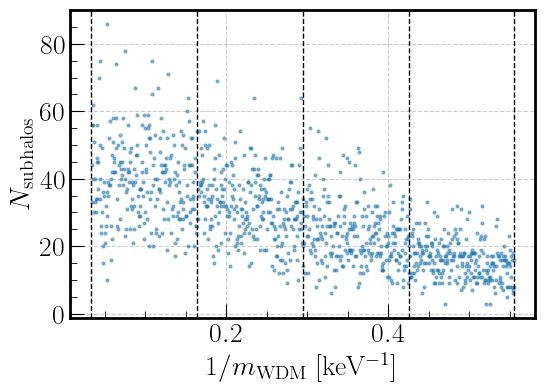

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(minv_wdm, num_subhalos, 'o', ms=2, alpha=0.5)

# create vertical lines for each mass bin
for i in range(len(minv_wdm_bins)):
    ax.axvline(minv_wdm_bins[i], color='k', ls='--', lw=1)

ax.set_xlabel(r'$1 / m_{\rm WDM}$ [keV$^{-1}$]')
ax.set_ylabel(r'$N_{\rm subhalos}$')

plt.show()